# How hard is it to make a computer find peaks in audio

TL;DR: very hard, it appears.
    
Suppose you have an audio signal and you want to detect peaks in it. Maybe you want to identify the beat in a song or you are trying to parse Morse code. In these situations you have a series of impulses which you can tell are louder than the rest of the audio. Even by just looking at a waveform, it is easy to tell that a peak has happened. Is it easy for a computer to do the same?

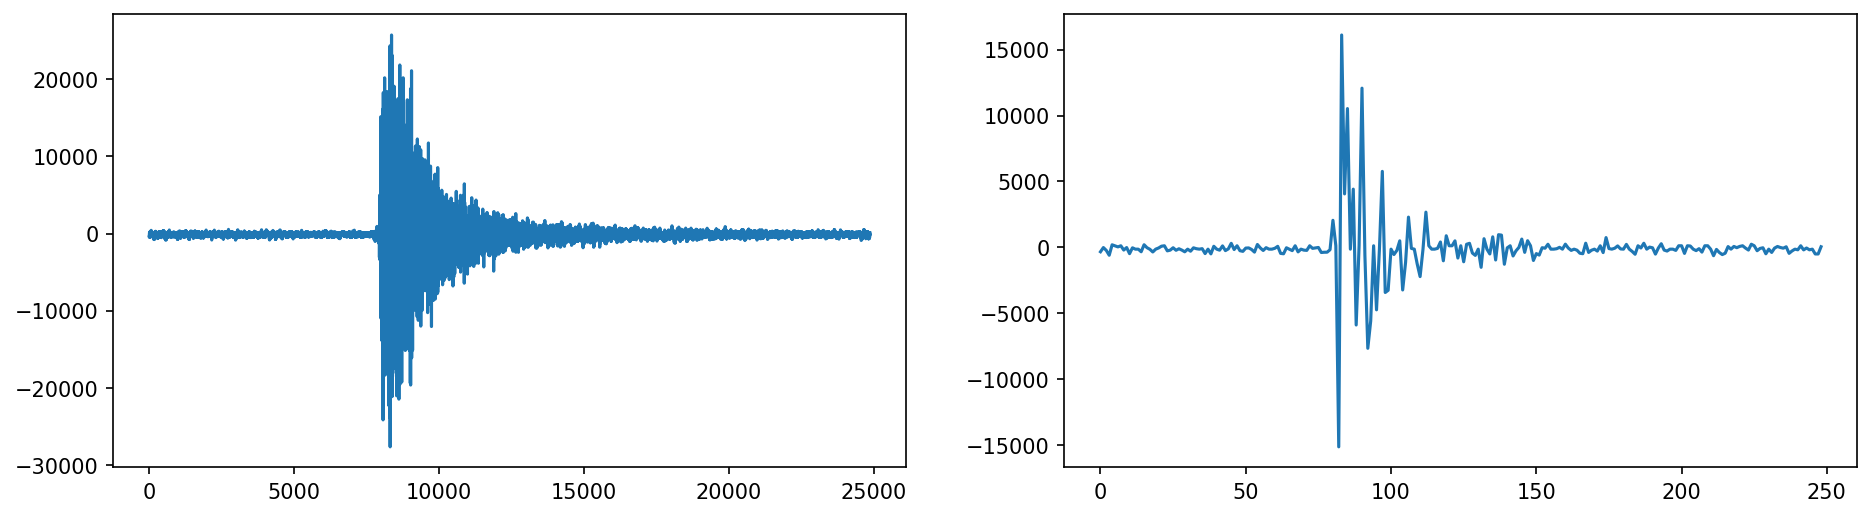

In [4]:
import aifc
import audioop as au
import numpy as np
from more_itertools import grouper
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline

set_matplotlib_formats('png')

def toint(frag, width):
    return list(map(lambda v: int.from_bytes(v, 'big', signed = True), grouper(frag, width)))

f = aifc.open('one-pop-1.aiff')
width = f.getsampwidth()
nsamples = f.getnframes()
raw = f.readframes(nsamples)
f.close()
mono = toint(au.tomono(raw, width, 1, 1), width)
fig = plt.figure(figsize=(15,4), dpi = 150)
ax1 = fig.add_subplot(1,2,1)
ax1.plot(mono)
ax2 = fig.add_subplot(1,2,2)
ax2.plot(mono[::100])
plt.show()

The pulses we are interested in might look like the ones above. In this representation of the *pop* we are looking at time on the horizontal axis versus amplitude on the vertical axis. The raw signal is shown in the leftmost graph, but there are so many data points that it almost looks like it has area under it. This is just an artifact produced by the lines that we use to visualize the waveform which join the data points. In the version to the right we have discarded 99% of the samples so that the fact that this is indeed a wave is clearer.

Back to our task of detecting peaks, one first idea is to find the local maxima of the function. This is relatively easy to do: a sample is a local maximum if and only if it is bigger than the to adjacent ones. Also, before proceeding any further, the function is kind of symmetric about the horizontal axis, so we can discard the negative part which will make things easier later [2]:

[2]: A more rigorous approach would have calculated the RMS value for tiny slices to reflect sound pressure more accurately.

In [5]:
def peaks1(x):
    res = []
    for i, v in enumerate(x[1:-1]):
        if x[i] < v and v > x[i + 2]:
            res.append((i, v))
    return res

# discard negative part
data1 = np.abs(mono)

print(f'{len(peaks1(mono))} out of {nsamples} are peaks')

5921 out of 24863 are peaks


Great, this first attempt reveals that around 25% of the samples are considered peaks under this definition of maximum. This attempt, has uncovered that the signal is indeed very, very wiggly. We can try to smooth it out by computing a moving average and working with that instead. In our context, the audio signal is a sequence of around 25000 values $x_1, x_2, \ldots$. A moving average of window size $W$ assigns to each point the average of the last $W$ points:
$$x_m = \frac{1}{W} \sum_{i = m - W}^m x_i.$$
We need to be careful with the first $W$ values, since there is not enough *history* to calculate the average. Similarly, there wont be enough *future* to calculate the average for the last $M$ values. This can be a bit tedious to implement, especially with these last edge cases. We can leverage the fact that a convolution with a boxcar function of width $M$ and height $1/M$ will yield the same results and that `numpy` already implements discrete convolutions.

In [6]:
W = 1000
data2 = np.convolve(data1, np.ones(W), 'valid') / W

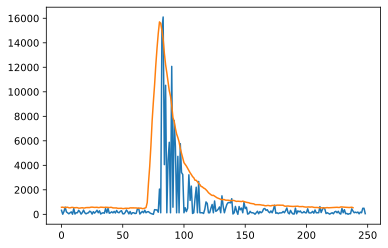

In [7]:
set_matplotlib_formats('svg')
plt.plot(data1[::100])
plt.plot(3 * data2[::100])
plt.show()

In the above plot we have also taken the chance and reduced the number of points we are using for the plots, since we have already realised that the data is super wiggly. The original data is still used for the analysis though.

If we try to find the peaks now we get

In [5]:
print(f'{len(peaks1(data2))} out of {nsamples} are peaks')

4585 out of 24863 are peaks


That is only a 20% reduction and we have used a window of 1000 samples! Even if we increase the window size (double it, even triple it), we still get thousands of peaks. Clearly, convolution is not helpful enough? But... what if we do it once more?

In [6]:
data3 = np.convolve(data2, np.ones(W), 'valid') / W

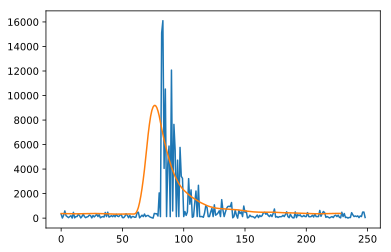

In [7]:
plt.plot(data1[::100])
plt.plot(2 * data3[::100])
plt.show()

Alright, the peak is slowly shifting to the left, but we don't care about that so much now, as long as we can find a peak:

In [8]:
print(f'{len(peaks1(data3))} out of {nsamples} are peaks')

31 out of 24863 are peaks


Okay, this has improved dramatically, but we still get 31 peaks. There must be a better way to do this but for the sake of completeness let's convolve a third time:

In [9]:
W = 1000
data4 = np.convolve(data3, np.ones(W), 'valid') / W
print(f'{len(peaks1(data4))} out of {nsamples} are peaks')

3 out of 24863 are peaks


While we are getting somewhere, this is taking way too much effort for our simple test with just one peak. We are still not able to count just one big peak. However, we are throwing away a ton of information: how big are these peaks, how far apart are they... Let's look at the three biggest peaks reported after each convolution:

In [10]:
print('1st convolution: ', sorted(peaks1(data2), key = lambda v: v[1], reverse = True)[:3])
print('2nd convolution: ', sorted(peaks1(data3), key = lambda v: v[1], reverse = True)[:3])
print('3rd convolution: ', sorted(peaks1(data4), key = lambda v: v[1], reverse = True)[:3])

1st convolution:  [(8046, 5412.995), (8056, 5403.334), (8033, 5394.965)]
2nd convolution:  [(7640, 4603.345313), (17143, 245.45059499999996), (18329, 219.05746100000002)]
3rd convolution:  [(7174, 4303.5119952939995), (16566, 241.88337264500004), (2165, 189.47858628800003)]


There is something very interesting going on:

 - First, as we expected there is a shift to the left in the highest reported peak. This is an artifact of the convolution and will not be a problem if we just want to *count* how many peaks there are.
 - Second, the first convolutions barely yields any results. For one, the first three peaks are equally high and very close together. Of course this tells us that there is a peak around there, but not how it relates to the rest of the signal without looking at all the peak list.
 - Third, the second convolution clearly calls a dominant peak. The other two who made it to the top three are both far apart and much lower.
 - Fourth, the third convolution, although it reduces the number of peaks, probably is not worth it since after we detect a dramatic increase in peak height from the first to the second detected peak we already have a candidate for mount Everest.

One possible reason for the dramatic increase in peak discrimination between the first and the second convolution is that data is much less wiggly (even though it still oscillates quite a lot) after the first convolution. This leads us to the question: do we need such a big window size for the second convolution? The answer appears to be no. Choosing a window size of 50 samples yields very similar results but with much less left-shift in the time coordinate where the peak is called:

In [11]:
data5 = np.convolve(data2, np.ones(50), 'valid') / 50
print('1st convolution: ', sorted(peaks1(data2), key = lambda v: v[1], reverse = True)[:3])
print('2nd convolution, smaller window: ', sorted(peaks1(data5), key = lambda v: v[1], reverse = True)[:3])

1st convolution:  [(8046, 5412.995), (8056, 5403.334), (8033, 5394.965)]
2nd convolution, smaller window:  [(8014, 5386.55954), (10938, 926.6066200000001), (10927, 926.48548)]


## Concluding remarks

This first look at the problem tells us that we cannot use the definition of a maximum common in Maths to find peaks in a waveform right away (precisely because it's a wave and we are looking for bigger scale features). It also tells us that the problem might can be greatly simplified by reducing the wiggly-ness of the data (via convolution or some other method) and that we may not need to go all the way until we find a single peak in a desired region if we introduce some notion of peak *prominence*. A more detailed characterization of this concept of prominence has the potential to reduce the number and scale of convolutions needed to be able to call peaks. Also, we have encountered an artifact of this method where the time at which a peak is called shifts to the left more and more with the number of convolutions performed. This is due to the asymmetric nature of the peaks we are dealing with, which may also prove to be a key determinant in our quest to find peaks in audio signals.